## Import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask
import os
from dask import dataframe as dd
from dask import array as da
from dask import delayed
dask.config.set(scheduler='threads')
import warnings
warnings.filterwarnings('ignore')
from PIL import Image

## Méthodes du projet

### Compute data methods

In [4]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    """ Affiche le pourcentage de chaque portion si la condition est vérifiée """
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

In [5]:
def show_unique_values(df, col, display_pie=True, silent=False):
    """
    Affiche la liste des valeurs uniques contenues dans une colonne
    Affiche le pie chart de ces données également
    """
    temp_val_count = df[col].value_counts(normalize=True).compute()
    df_val_count = temp_val_count.rename_axis("label").to_frame("%")
    df_val_count["%"] = round(df_val_count["%"]*100, 2)
    df_val_count["%_cumul"] = df_val_count["%"].cumsum()
    # afficher la majeur partie des catégories
    sub_display = df_val_count.loc[df_val_count["%_cumul"] <= 85, :]
    
    if silent:
        return sub_display
    
    if len(sub_display) < 5:
        display(df_val_count.head())
    else:
        display(sub_display.head(len(sub_display)))
    if display_pie:
        temp_val_count.plot(kind='pie', autopct=show_perc, labels=show_labels(temp_val_count), label='')
        plt.axis('equal')
        plt.show()
    return sub_display

In [6]:
def extract_restaurant_data():
    businesses = dd.read_json("yelp_dataset/yelp_academic_dataset_business.json",lines = True, encoding = 'utf-8', blocksize="100MB")
    businesses = businesses.drop(columns=["address", "city", "state", "postal_code", "latitude", "longitude", "attributes", "hours", "is_open", "review_count", "stars"])
    restaurant_data = businesses.loc[(businesses["categories"].notnull()) & (businesses["categories"].str.contains("restaurant", case=False)), :]
    restaurant_data = restaurant_data.drop(columns=["categories"])
    restaurant_data = restaurant_data.compute()
    return restaurant_data

### Searching for descriptors methods

In [7]:
def get_descriptor_model(model_name="SIFT"):
    if model_name == "SIFT":
        return cv2.SIFT_create(500)
    elif model_name == "ORB":
        return cv2.ORB_create(500)
    elif model_name == "SURF":
        return cv2.SURF_create()
    else:
        return -1

In [8]:
import time, cv2
def extract_descriptors(model_name, list_photos):
    model = get_descriptor_model(model_name)
    model_keypoints = []
    temps1 = time.time()
    
    for image_num in range(len(list_photos)) :
        if image_num % 100 == 0 : print(image_num)
        image = cv2.imread("yelp_photos/photos/" + list_photos[image_num] + ".jpg", cv2.IMREAD_GRAYSCALE) # convert in gray
        image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)
        res = cv2.equalizeHist(image) # equalize image histogram
        kp, des = model.detectAndCompute(res, None)
        model_keypoints.append(des)
        
    model_keypoints_by_img = np.asarray(model_keypoints, dtype=object)
    model_keypoints_all    = np.concatenate(model_keypoints_by_img, axis=0)

    print("Nombre de descripteurs : ", model_keypoints_all.shape)
    duration1=time.time()-temps1
    print("Temps de traitement", model_name, "descriptor : ", "%15.2f" % duration1, "secondes")
    
    return model_keypoints_by_img, model_keypoints_all

In [9]:
from sklearn import cluster, metrics
def cluster_descriptors(model_keypoints_all, nb_categ, meth_nd_clusters="sqrt"):
    temps1=time.time()
    
    # nb of cluster
    if meth_nd_clusters == "sqrt":
        k = int(round(np.sqrt(len(model_keypoints_all)),0))
    elif meth_nd_clusters == "categ":
        k = nb_categ * 10
    
    print("Nombre de clusters estimés : ", k)
    print("Création de", k, "clusters de descripteurs ...")

    kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42)
    # kmeans = cluster.KMeans(n_clusters=k, random_state=42)
    kmeans.fit(model_keypoints_all)

    duration1 = time.time() - temps1
    print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")
    
    return kmeans

In [10]:
def build_histogram(trained_kmeans, des, image_num):
    res = trained_kmeans.predict(des)
    hist = np.zeros(len(trained_kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [11]:
def create_histograms_from_keypoints(model_keypoints_by_img, trained_kmeans):
    temps1 = time.time()
    hist_vectors=[]

    for i, image_desc in enumerate(model_keypoints_by_img) :
        if i%100 == 0 : print(i)  
        hist = build_histogram(trained_kmeans, image_desc, i) #calculates the histogram
        hist_vectors.append(hist) #histogram is the feature vector

    im_features = np.asarray(hist_vectors)

    duration1 = time.time() - temps1
    print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")
    
    return im_features

In [12]:
from sklearn import manifold, decomposition
def reducing_by_pca(im_features, n_components=0.99):
    print("Dimensions dataset avant réduction PCA : ", im_features.shape)
    pca = decomposition.PCA(n_components=n_components)
    feat_pca= pca.fit_transform(im_features)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
    
    return feat_pca

In [13]:
def get_feature2(l_model, i_img_path):
    l_img = load_img(i_img_path,target_size=(224,224))
    l_x = img_to_array(l_img)
    l_x = np.expand_dims(l_x,axis=0)
    l_x = preprocess_input(l_x)
    l_features = l_model.predict(l_x,verbose=0)
    return l_features

In [14]:
import time
def extract_descriptors_cnn(list_photos):
    # instance du model VGG16 sans la dernière couche
    model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape= (224, 224, 3))
    x = model_vgg16.output
    model_output = Flatten()(x)
    # on crée une nouvelle dernière couche
    model_for_features = Model(inputs=model_vgg16.input, outputs=model_output)
    
    model_keypoints = []
    temps1 = time.time()
    
    for image_num in range(len(list_photos)) :
        if image_num % 100 == 0 : print(image_num)
        photo_name = "yelp_photos/photos/" + list_photos[image_num] + ".jpg"
        img_feat = get_feature2(model_for_features, photo_name)
        model_keypoints.append(img_feat)
        
    model_keypoints_by_img = np.asarray(model_keypoints, dtype=object)
    model_keypoints_all    = np.concatenate(model_keypoints_by_img, axis=0)

    print("Nombre de descripteurs : ", model_keypoints_all.shape)
    duration1=time.time()-temps1
    print("Temps de traitement CNN VGG16 descriptor : ", "%15.2f" % duration1, "secondes")
    
    return model_keypoints_by_img, model_keypoints_all

### Display t-SNE methods

In [15]:
from sklearn import manifold, decomposition
def compute_tsne(data, feat_pca):
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=42)
    X_tsne = tsne.fit_transform(feat_pca)

    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    df_tsne["label"] = data["label"]
    
    return df_tsne, X_tsne

In [16]:
def display_tsne_plot(df, hue):
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", y="tsne2", hue=hue, data=df, legend="brief",
        palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

    plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    plt.legend(prop={'size': 14}) 

    plt.show()

In [17]:
from sklearn import cluster, metrics
def clustering_from_tsne_data(data, df, X_tsne):
    tsne_clust = cluster.KMeans(n_clusters=5, random_state=42)
    tsne_clust.fit(X_tsne)
    df["cluster"] = tsne_clust.labels_
    print("ARI : ", metrics.adjusted_rand_score(data["label"], tsne_clust.labels_))
    return df

In [44]:
def display_tsne_plot_dbl(df, hue1, hue2):
    fig, axs = plt.subplots(1, 2, figsize=(16,5))
    sns.scatterplot(
        x="tsne1", y="tsne2", hue=hue1, data=df, legend="brief",
        palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6, ax=axs[0])
    
    sns.scatterplot(
        x="tsne1", y="tsne2", hue=hue2, data=df, legend="brief",
        palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6, ax=axs[1])

    axs[0].set_title('T-SNE clustering réel')
    axs[1].set_title('T-SNE clustering théorique')
    plt.show()

In [19]:
def compute_mapping_labels(list_labels, photos_sample):
    mapping_labels = []
    for i, name in enumerate(list_labels):
        photos_sample.loc[photos_sample["label"]==name, "label_num"] = i
        mapping_labels.append(name)
    return mapping_labels

### Display confusion matrix methods

In [20]:
import itertools
def find_corresponding_labels(df, list_labels):
    
    best_res = ()
    for combinations in list(itertools.permutations(list_labels)):
        for i, name in enumerate(combinations):           
            df.loc[df["cluster"]==i, "cluster_name"] = name
        accuracy_score = metrics.accuracy_score(df["label"], df["cluster_name"])
        if not best_res or accuracy_score > best_res[1]:
            best_res = (combinations, accuracy_score)
            print("Best score so far :", best_res)
    
    # use the best result
    for i, name in enumerate(best_res[0]):
        df.loc[df["cluster"]==i, "cluster_name"] = name
    
    return df, best_res

In [21]:
def display_confusion_matrix(actual_class, predict_class, display_labels=None):
    print("Calcul et affichage de la matrice de confusion")
    # pour calculer la matrice de confusion
    cm = metrics.confusion_matrix(actual_class, predict_class, labels=display_labels)
    cm = cm.T
    
    # pour afficher la matrice de confusion
    displ = metrics.ConfusionMatrixDisplay(cm, display_labels=display_labels)
    displ.plot()
    displ.ax_.xaxis.tick_top()
    displ.ax_.xaxis.set_label_position('top') 
    plt.xlabel('Actual Label')
    plt.ylabel('Predicted Label')
    plt.gcf().axes[0].tick_params()
    plt.gcf().axes[1].tick_params()
    plt.show()

In [22]:
def display_classification_report(actual_class, predict_class, display_labels=None):
    print("Calcul et affichage du rapport de classification")
    clf_report = metrics.classification_report(actual_class, predict_class, target_names=display_labels)
    print(clf_report)

## Data

In [23]:
photos = dd.read_json("yelp_photos/photos.json",lines = True, encoding = 'utf-8', blocksize="100MB")

In [24]:
photos.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [25]:
restaurant_data = extract_restaurant_data()

In [26]:
restaurant_photos = photos.loc[photos["business_id"].isin(restaurant_data["business_id"]), :]
restaurant_photos = restaurant_photos.drop(columns=["business_id", "caption"])

,%,%_cumul
label,,
food,58.14,58.14
inside,25.70,83.84
outside,8.70,92.54
drink,6.61,99.15
menu,0.85,100.00


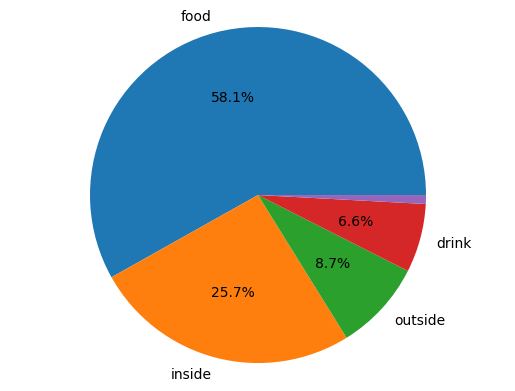

In [27]:
res = show_unique_values(restaurant_photos, "label")

In [28]:
photos_sample = restaurant_photos.groupby(['label']).apply(pd.DataFrame.sample, n=200, replace=True, random_state=42).reset_index(drop=True)
photos_sample = photos_sample.compute()

In [29]:
list_photos = photos_sample["photo_id"].values.tolist()

## Process pictures

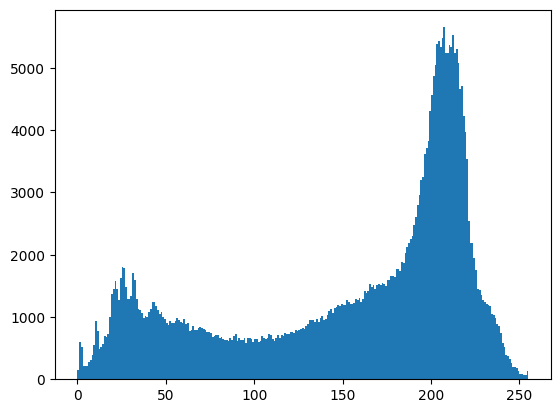

In [30]:
for photo in photos_sample.itertuples():
    img_path = os.path.join("yelp_photos/photos", f"{photo.photo_id}.jpg")
    # img = Image.open(img_path)
    # img.show()
    img = np.array(Image.open(img_path))
    n, bins, patches = plt.hist(img.flatten(), bins=range(256))
    plt.show()
    break

## Webinar processes

### Display random pictures

food


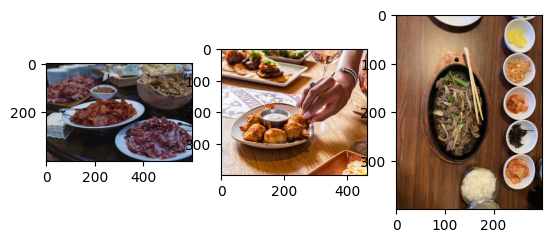

inside


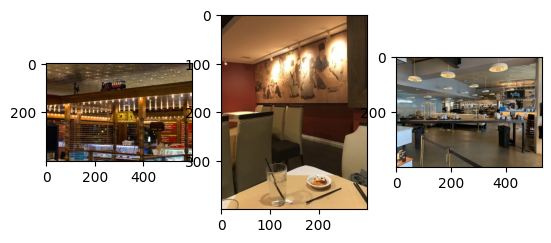

outside


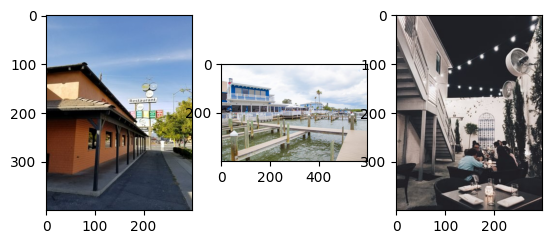

drink


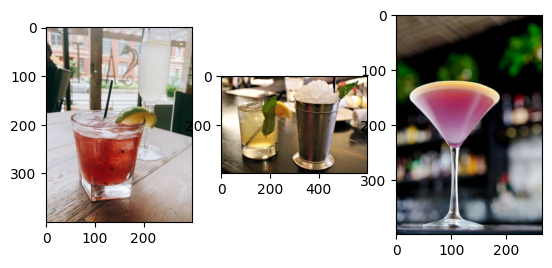

menu


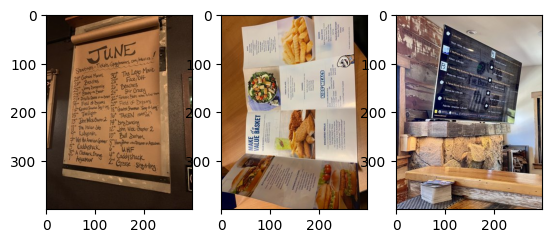

In [31]:
from matplotlib.image import imread

list_labels = ["food", "inside", "outside", "drink", "menu"]

for name in list_labels :
    print(name)
    # print("-------")
    temp_labeled_photos = photos_sample.loc[photos_sample["label"] == name, :].reset_index(drop=True)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        name = temp_labeled_photos.iloc[i, 0]
        img_path = os.path.join("yelp_photos/photos", f"{name}.jpg")
        image = imread(img_path)
        plt.imshow(image)
    plt.show()

### one picture

In [42]:
def extract_descriptors_from_single_photo(photo_name, model_name):
    model = get_descriptor_model(model_name)
    
    stem_pic_name = photo_name.split("/")[-1]
    print("Compute", model_name, "model to the picture", stem_pic_name)
    image = imread(photo_name)
    print("Image brute :")
    plt.imshow(image)
    plt.show()
    image = cv2.imread(photo_name, cv2.IMREAD_GRAYSCALE)
    print("Image en noir et blanc :")
    plt.imshow(image, cmap='gray')
    plt.show()
    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)
    print("Image sans bruit :")
    plt.imshow(image, cmap='gray')
    plt.show()
    image = cv2.equalizeHist(image)  # equalize image histogram
    print("Image égalisée :")
    plt.imshow(image, cmap='gray')
    plt.show()
    
    kp, des = model.detectAndCompute(image, None)
    img=cv2.drawKeypoints(image, kp, image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # keypoint with size and direction
    
    print("Extraction descripteurs :")
    plt.imshow(img)
    plt.show()
    return image

Compute SIFT model to the picture ahM2Rv7NBGUQGUlCClLYZw.jpg
Image brute :


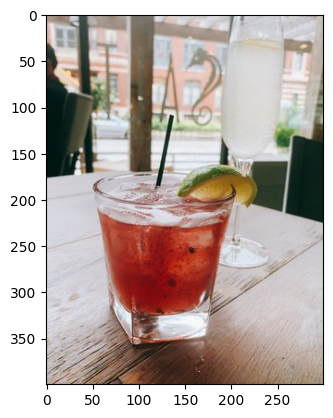

Image en noir et blanc :


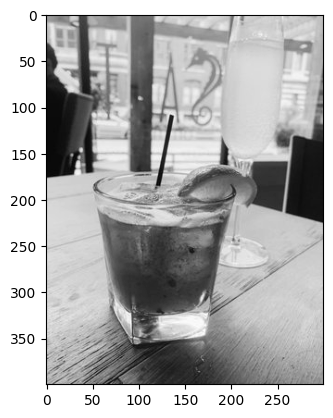

Image sans bruit :


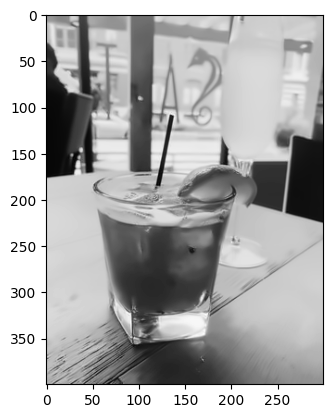

Image égalisée :


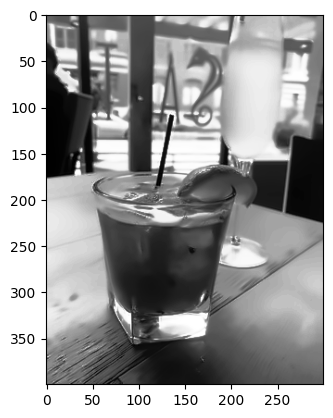

Extraction descripteurs :


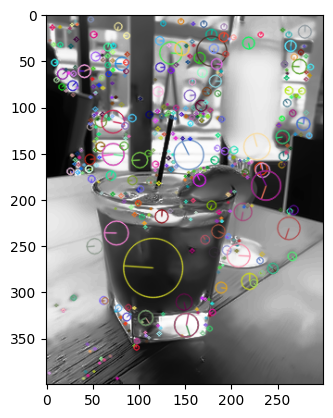

In [43]:
photo_name = "yelp_photos/photos/" + list_photos[0] + ".jpg"
for mod in ["SIFT", "ORB"]:
    image = extract_descriptors_from_single_photo(photo_name, model_name=mod)
    break

### Use of model descriptors OpenCV

### SIFT and ORB (sqrt)

0
100
200
300
400
500
600
700
800
900
Nombre de descripteurs :  (450168, 128)
Temps de traitement SIFT descriptor :            73.22 secondes
Nombre de clusters estimés :  671
Création de 671 clusters de descripteurs ...
temps de traitement kmeans :             5.11 secondes
0
100
200
300
400
500
600
700
800
900
temps de création histogrammes :             0.76 secondes
Dimensions dataset avant réduction PCA :  (1000, 671)
Dimensions dataset après réduction PCA :  (1000, 532)
ARI :  0.1574471601034349


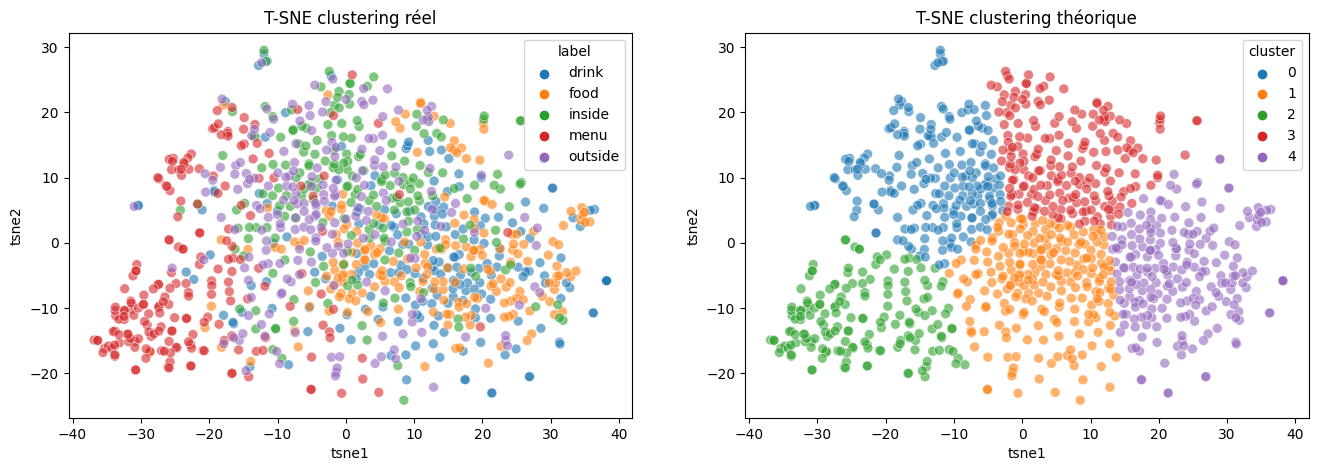

Best score so far : (('food', 'inside', 'outside', 'drink', 'menu'), 0.094)
Best score so far : (('food', 'inside', 'outside', 'menu', 'drink'), 0.149)
Best score so far : (('food', 'inside', 'menu', 'outside', 'drink'), 0.306)
Best score so far : (('food', 'outside', 'menu', 'inside', 'drink'), 0.348)
Best score so far : (('inside', 'food', 'menu', 'outside', 'drink'), 0.383)
Best score so far : (('outside', 'food', 'menu', 'inside', 'drink'), 0.43)
Calcul et affichage de la matrice de confusion


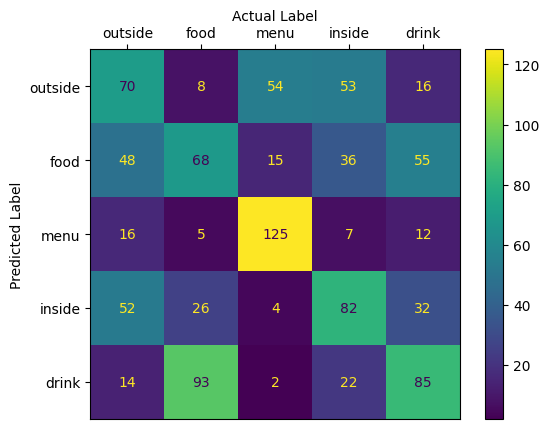

Calcul et affichage du rapport de classification
              precision    recall  f1-score   support

       drink       0.39      0.42      0.41       200
        food       0.31      0.34      0.32       200
      inside       0.42      0.41      0.41       200
        menu       0.76      0.62      0.68       200
     outside       0.35      0.35      0.35       200

    accuracy                           0.43      1000
   macro avg       0.44      0.43      0.44      1000
weighted avg       0.44      0.43      0.44      1000



In [45]:
for mod in ["SIFT", "ORB"]:
    # searching for descriptors part
    model_keypoints_by_img, model_keypoints_all = extract_descriptors(mod, list_photos)
    trained_kmeans = cluster_descriptors(model_keypoints_all, nb_categ=5, meth_nd_clusters="sqrt")
    im_features = create_histograms_from_keypoints(model_keypoints_by_img, trained_kmeans)
    feat_pca = reducing_by_pca(im_features)

    # display t-SNE graph part
    df_tsne, X_tsne = compute_tsne(photos_sample, feat_pca)
    df_tsne = clustering_from_tsne_data(photos_sample, df_tsne, X_tsne)
    # display_tsne_plot(df_tsne, "label")
    display_tsne_plot_dbl(df_tsne, "label", "cluster")

    # confusion matrix part
    df_tsne, best_res = find_corresponding_labels(df_tsne, list_labels)
    display_confusion_matrix(actual_class=df_tsne["label"], predict_class=df_tsne["cluster_name"], display_labels=best_res[0])
    display_classification_report(actual_class=df_tsne["label"], predict_class=df_tsne["cluster_name"])
    break

## Neural Network

In [46]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Dense, Flatten
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.models import Model

2023-06-16 15:58:47.566891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 15:58:47.632370: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-16 15:58:47.634441: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: Ne peut ouvrir le fichier d'objet partagé: Aucun fichier ou dossier de ce type; LD_LIBRARY_PATH: /home/slerendu/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-

In [47]:
model_keypoints_by_img, model_keypoints_all = extract_descriptors_cnn(list_photos)

2023-06-16 15:58:48.324819: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: Ne peut ouvrir le fichier d'objet partagé: Aucun fichier ou dossier de ce type; LD_LIBRARY_PATH: /home/slerendu/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-06-16 15:58:48.324833: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-16 15:58:48.324844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sle-machina): /proc/driver/nvidia/version does not exist
2023-06-16 15:58:48.324973: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild Tens

0
100
200
300
400
500
600
700
800
900
Nombre de descripteurs :  (1000, 25088)
Temps de traitement CNN VGG16 descriptor :           111.77 secondes


Dimensions dataset avant réduction PCA :  (1000, 25088)
Dimensions dataset après réduction PCA :  (1000, 919)
ARI :  0.3904312043276365


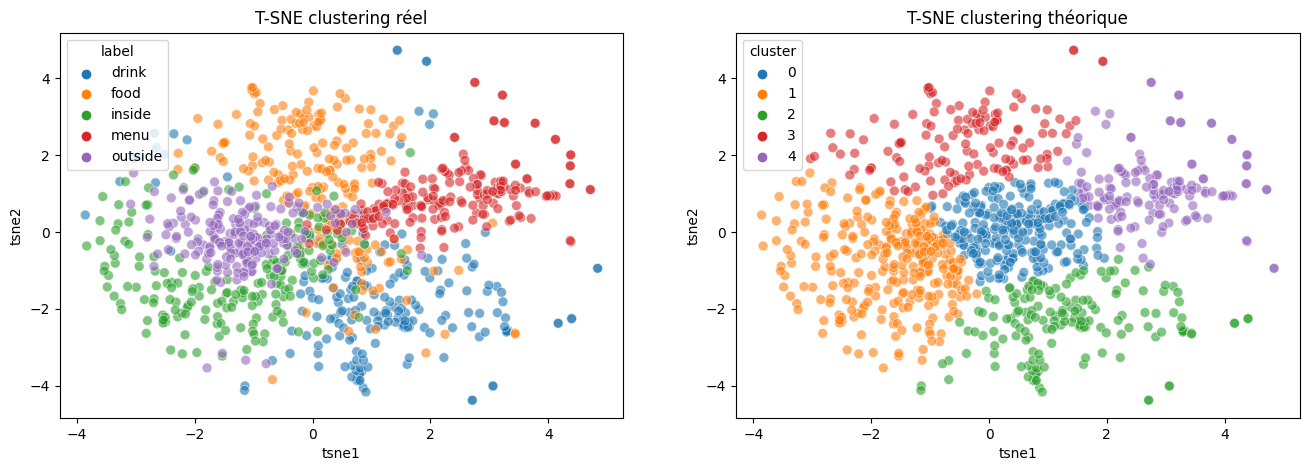

Best score so far : (('food', 'inside', 'outside', 'drink', 'menu'), 0.362)
Best score so far : (('food', 'inside', 'drink', 'outside', 'menu'), 0.496)
Best score so far : (('food', 'outside', 'drink', 'inside', 'menu'), 0.506)
Best score so far : (('inside', 'outside', 'drink', 'food', 'menu'), 0.592)
Calcul et affichage de la matrice de confusion


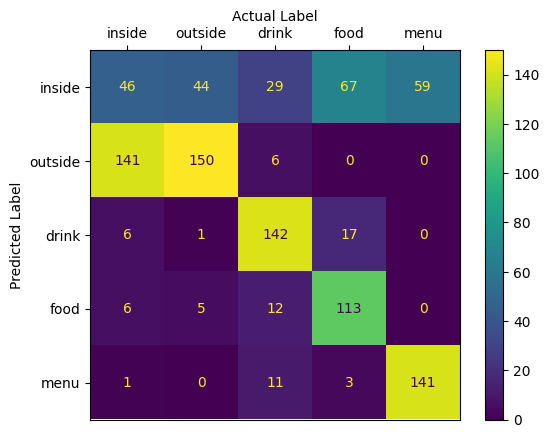

Calcul et affichage du rapport de classification
              precision    recall  f1-score   support

       drink       0.86      0.71      0.78       200
        food       0.83      0.56      0.67       200
      inside       0.19      0.23      0.21       200
        menu       0.90      0.70      0.79       200
     outside       0.51      0.75      0.60       200

    accuracy                           0.59      1000
   macro avg       0.66      0.59      0.61      1000
weighted avg       0.66      0.59      0.61      1000



In [48]:
feat_pca = reducing_by_pca(model_keypoints_all)

# display t-SNE graph part
df_tsne, X_tsne = compute_tsne(photos_sample, feat_pca)
df_tsne = clustering_from_tsne_data(photos_sample, df_tsne, X_tsne)
display_tsne_plot_dbl(df_tsne, "label", "cluster")

# confusion matrix part
df_tsne, best_res = find_corresponding_labels(df_tsne, list_labels)
display_confusion_matrix(actual_class=df_tsne["label"], predict_class=df_tsne["cluster_name"], display_labels=best_res[0])
display_classification_report(actual_class=df_tsne["label"], predict_class=df_tsne["cluster_name"])

ARI :  0.4183072652691097


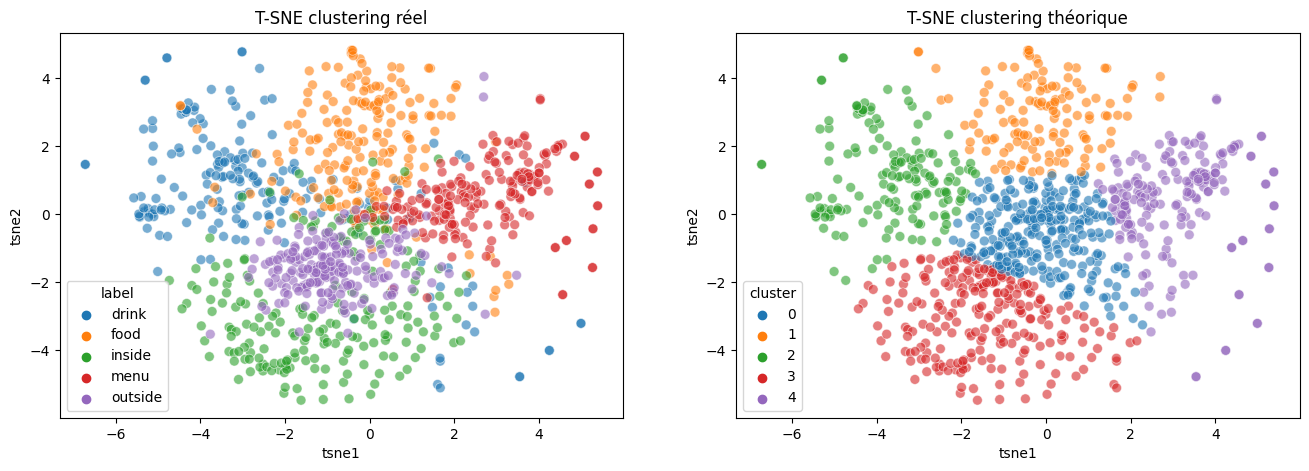

Best score so far : (('food', 'inside', 'outside', 'drink', 'menu'), 0.228)
Best score so far : (('food', 'inside', 'drink', 'outside', 'menu'), 0.455)
Best score so far : (('food', 'outside', 'drink', 'inside', 'menu'), 0.511)
Best score so far : (('inside', 'food', 'drink', 'outside', 'menu'), 0.568)
Best score so far : (('outside', 'food', 'drink', 'inside', 'menu'), 0.685)
Calcul et affichage de la matrice de confusion


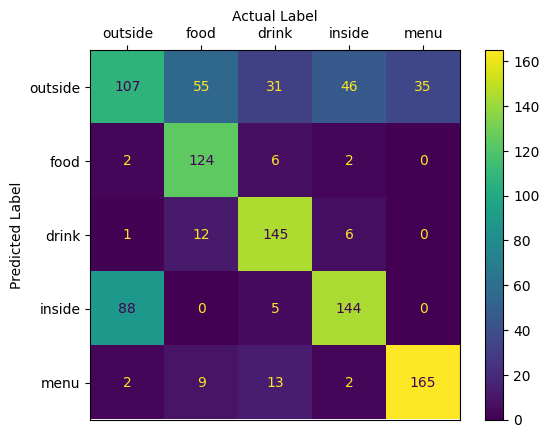

Calcul et affichage du rapport de classification
              precision    recall  f1-score   support

       drink       0.88      0.72      0.80       200
        food       0.93      0.62      0.74       200
      inside       0.61      0.72      0.66       200
        menu       0.86      0.82      0.84       200
     outside       0.39      0.54      0.45       200

    accuracy                           0.69      1000
   macro avg       0.73      0.68      0.70      1000
weighted avg       0.73      0.69      0.70      1000



In [49]:
# sans réduction par PCA

# display t-SNE graph part
df_tsne, X_tsne = compute_tsne(photos_sample, model_keypoints_all)
df_tsne = clustering_from_tsne_data(photos_sample, df_tsne, X_tsne)
display_tsne_plot_dbl(df_tsne, "label", "cluster")

# confusion matrix part
df_tsne, best_res = find_corresponding_labels(df_tsne, list_labels)
display_confusion_matrix(actual_class=df_tsne["label"], predict_class=df_tsne["cluster_name"], display_labels=best_res[0])
display_classification_report(actual_class=df_tsne["label"], predict_class=df_tsne["cluster_name"])